In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using YAXArrays
using Zarr
using Dates


  Activating project at `~/workspace/uni/spatial_temporal_data/spatio_temporal_data-rainforest_development`


In [84]:
include("src/rainforest_lib.jl")
using .Rainforestlib

In [86]:
lc = Rainforestlib.get_lcc_datacube()


YAXArray with the following dimensions
lon                 Axis with 32400 Elements from -179.9986111111111 to 179.9902777777778
lat                 Axis with 16200 Elements from 89.99027777777778 to -89.99861111111112
time                Axis with 11 Elements from 2010-01-01T00:00:00 to 2020-01-01T00:00:00
name: lccs_class
Total size: 5.38 GB


In [87]:
filtered_dc = Rainforestlib.rough_spatial_filter(lc; time_bounds = (Date(2010), Date(2020)))


YAXArray with the following dimensions
lon                 Axis with 5400 Elements from -89.9986111111111 to -30.009722222222205
lat                 Axis with 4050 Elements from 14.990277777777777 to -29.99861111111111
time                Axis with 10 Elements from 2010-01-01T00:00:00 to 2019-01-01T00:00:00
name: lccs_class
Total size: 208.57 MB


┌ Warning: Could not find font regular, using TeX Gyre Heros Makie
└ @ Makie /home/denis/.julia/packages/Makie/iECbF/src/conversions.jl:993


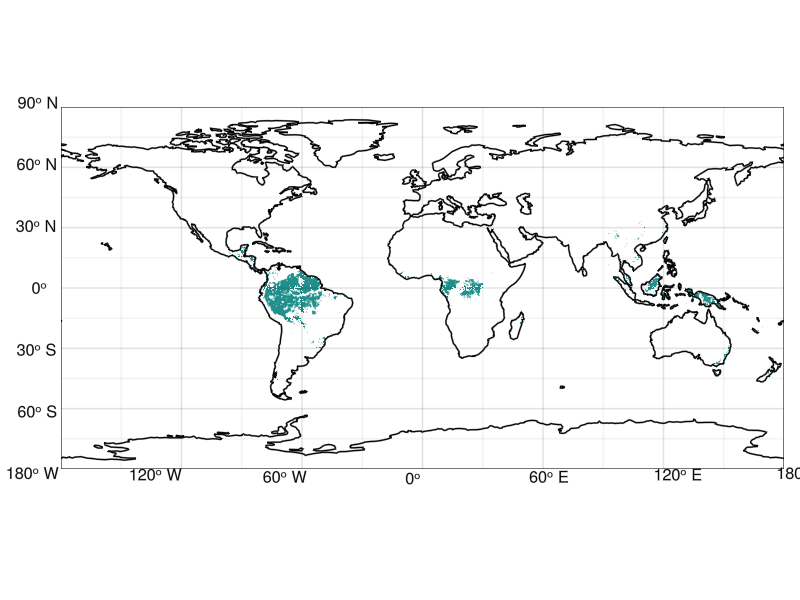

In [15]:
using .RainforestLib

# set a set of accepted values
accepted_values = Set(["tree_broadleaved_evergreen_closed_to_open"])

# WARNING: do not try this with the huge datacube, it wont work. The in function needs to be ported to datacubes, the native one is not working
# to create the world map, simply set local_map=false
global_figure = Rainforestlib.build_figure_by_lcc_classes(lc, Set(["tree_broadleaved_evergreen_closed_to_open"]), false)

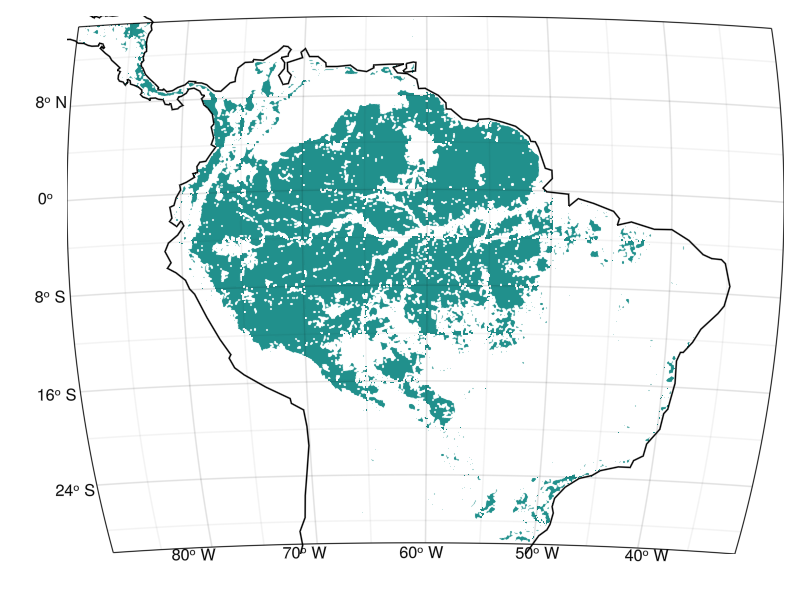

In [12]:
using .Rainforestlib

# local is the default, and makes the map as large as the datapoints
# but can me changed by setting 
local_figure = Rainforestlib.build_figure_by_lcc_classes(filtered_dc, accepted_values)

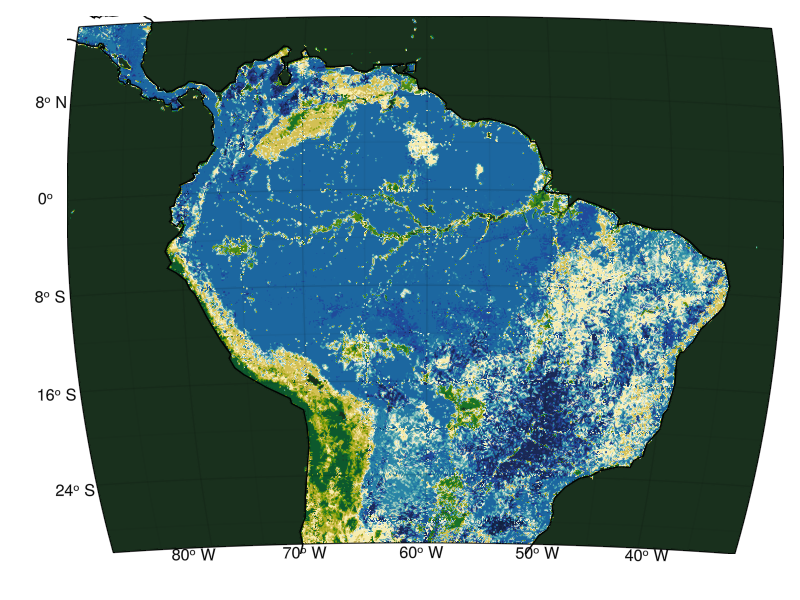

In [37]:
using .Rainforestlib

local_figure = Rainforestlib.build_figure_all_classes(filtered_dc; colormap = :delta)

Number of rainforest pixels in 2010-01-01T00:00:00: 4.614232e6
Diff to last: 4.614232e6


Number of rainforest pixels in 2011-01-01T00:00:00: 4.611793e6
Diff to last: -2439.0


Number of rainforest pixels in 2012-01-01T00:00:00: 4.611263e6
Diff to last: -530.0


Number of rainforest pixels in 2013-01-01T00:00:00: 4.610353e6
Diff to last: -910.0


Number of rainforest pixels in 2014-01-01T00:00:00: 4.613331e6
Diff to last: 2978.0


Number of rainforest pixels in 2015-01-01T00:00:00: 4.613325e6
Diff to last: -6.0


Number of rainforest pixels in 2016-01-01T00:00:00: 4.615178e6
Diff to last: 1853.0


Number of rainforest pixels in 2017-01-01T00:00:00: 4.61473e6
Diff to last: -448.0


Number of rainforest pixels in 2018-01-01T00:00:00: 4.613133e6
Diff to last: -1597.0


Number of rainforest pixels in 2019-01-01T00:00:00: 4.614627e6
Diff to last: 1494.0


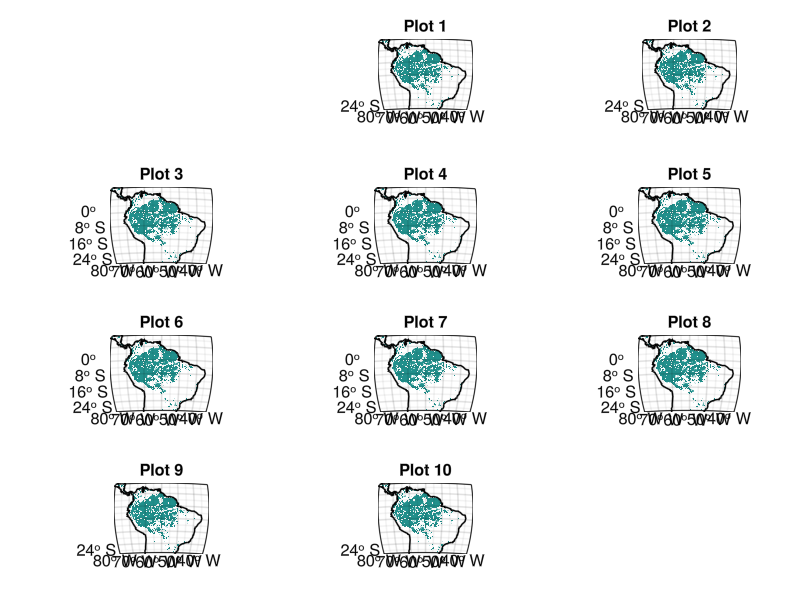

In [88]:
Rainforestlib.build_plots_over_time(filtered_dc, accepted_values)